<a href="https://colab.research.google.com/github/kina19131/Machine-Learning-Algorithm/blob/master/Introduction_to_ML_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Remark: please answer each question in its own cell.**

On Quercus, submit both a PDF printout of your assignment (for easier grading) and the ipynb file.

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [ ]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 50 kB 4.6 MB/s 


In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 160MB/s] 


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1 [1 points]: In your own words, explain what does "fit_on_texts" do?** 

When a sentence is fed in, this function will break down the sentence into vocabularies and update the dictionary based on the word frequency. Lower index means higher frequency of the word. Another note on the indicies is that the indexing starts from 1 since 0 is reserved for padding. 

**Question 2 [1 points]: In your own words, explain what does "texts_to_sequences" do?**

This function will encode the texts into its corresponding integers (index) in the dictionary. 

If the word does not exist in the dictionary, it is skipped. 


**Question 3 [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it?**

Takes a list that has a length of the number of samples into a 2D numpy array shape - number of samples x number of timesteps (max lenght or longest sequence in the list). 

If the sequence is shorter than the timesteps, it is "padded" with value until the two have the same lenght.

If the length of the sequence is greater than the number of timesteps, the sequence is truncated and is set to the desired length. 

Pad_sequences is used to make it so that  all the sequences in the list have the same length. 


In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [ ]:
print(messages_train[2], '\n')
print('length of messages_train[2]:', len(messages_train[2]))
print('length of messages_train[2]:', len(messages_train[1]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    3 1364
  112   64    4    1 1245   15   20 1715    2   85   11    6  328   31
   83    5 1398    5  252   79    1   64   20    3   35  487   34   72
    5   26    3 1666   14   69   14    3   49  658    2  361    3 1426
    6   52    5   87   14    1   64   73   63    1 1334 1794    1    8
   24  858  301 1481    2   85   28   16    1 1523   12  391   87    3
  311 

As explored above, inputted strings are encoded into integers (indexes) in the dictionary. The sequence of these numbers are in the shape of a 2D matrix performed by the 'pad_sequences' function. Also, there are placeholder 0's  to keep the size of the matrix the same across all the sentences. 

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points] Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?**

`__init__` keeps the trainable weights of the input neural networks (in this case, this is the xavier_truncated_normal). \\
`__call__` returns the values of the trainables weights. 


# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

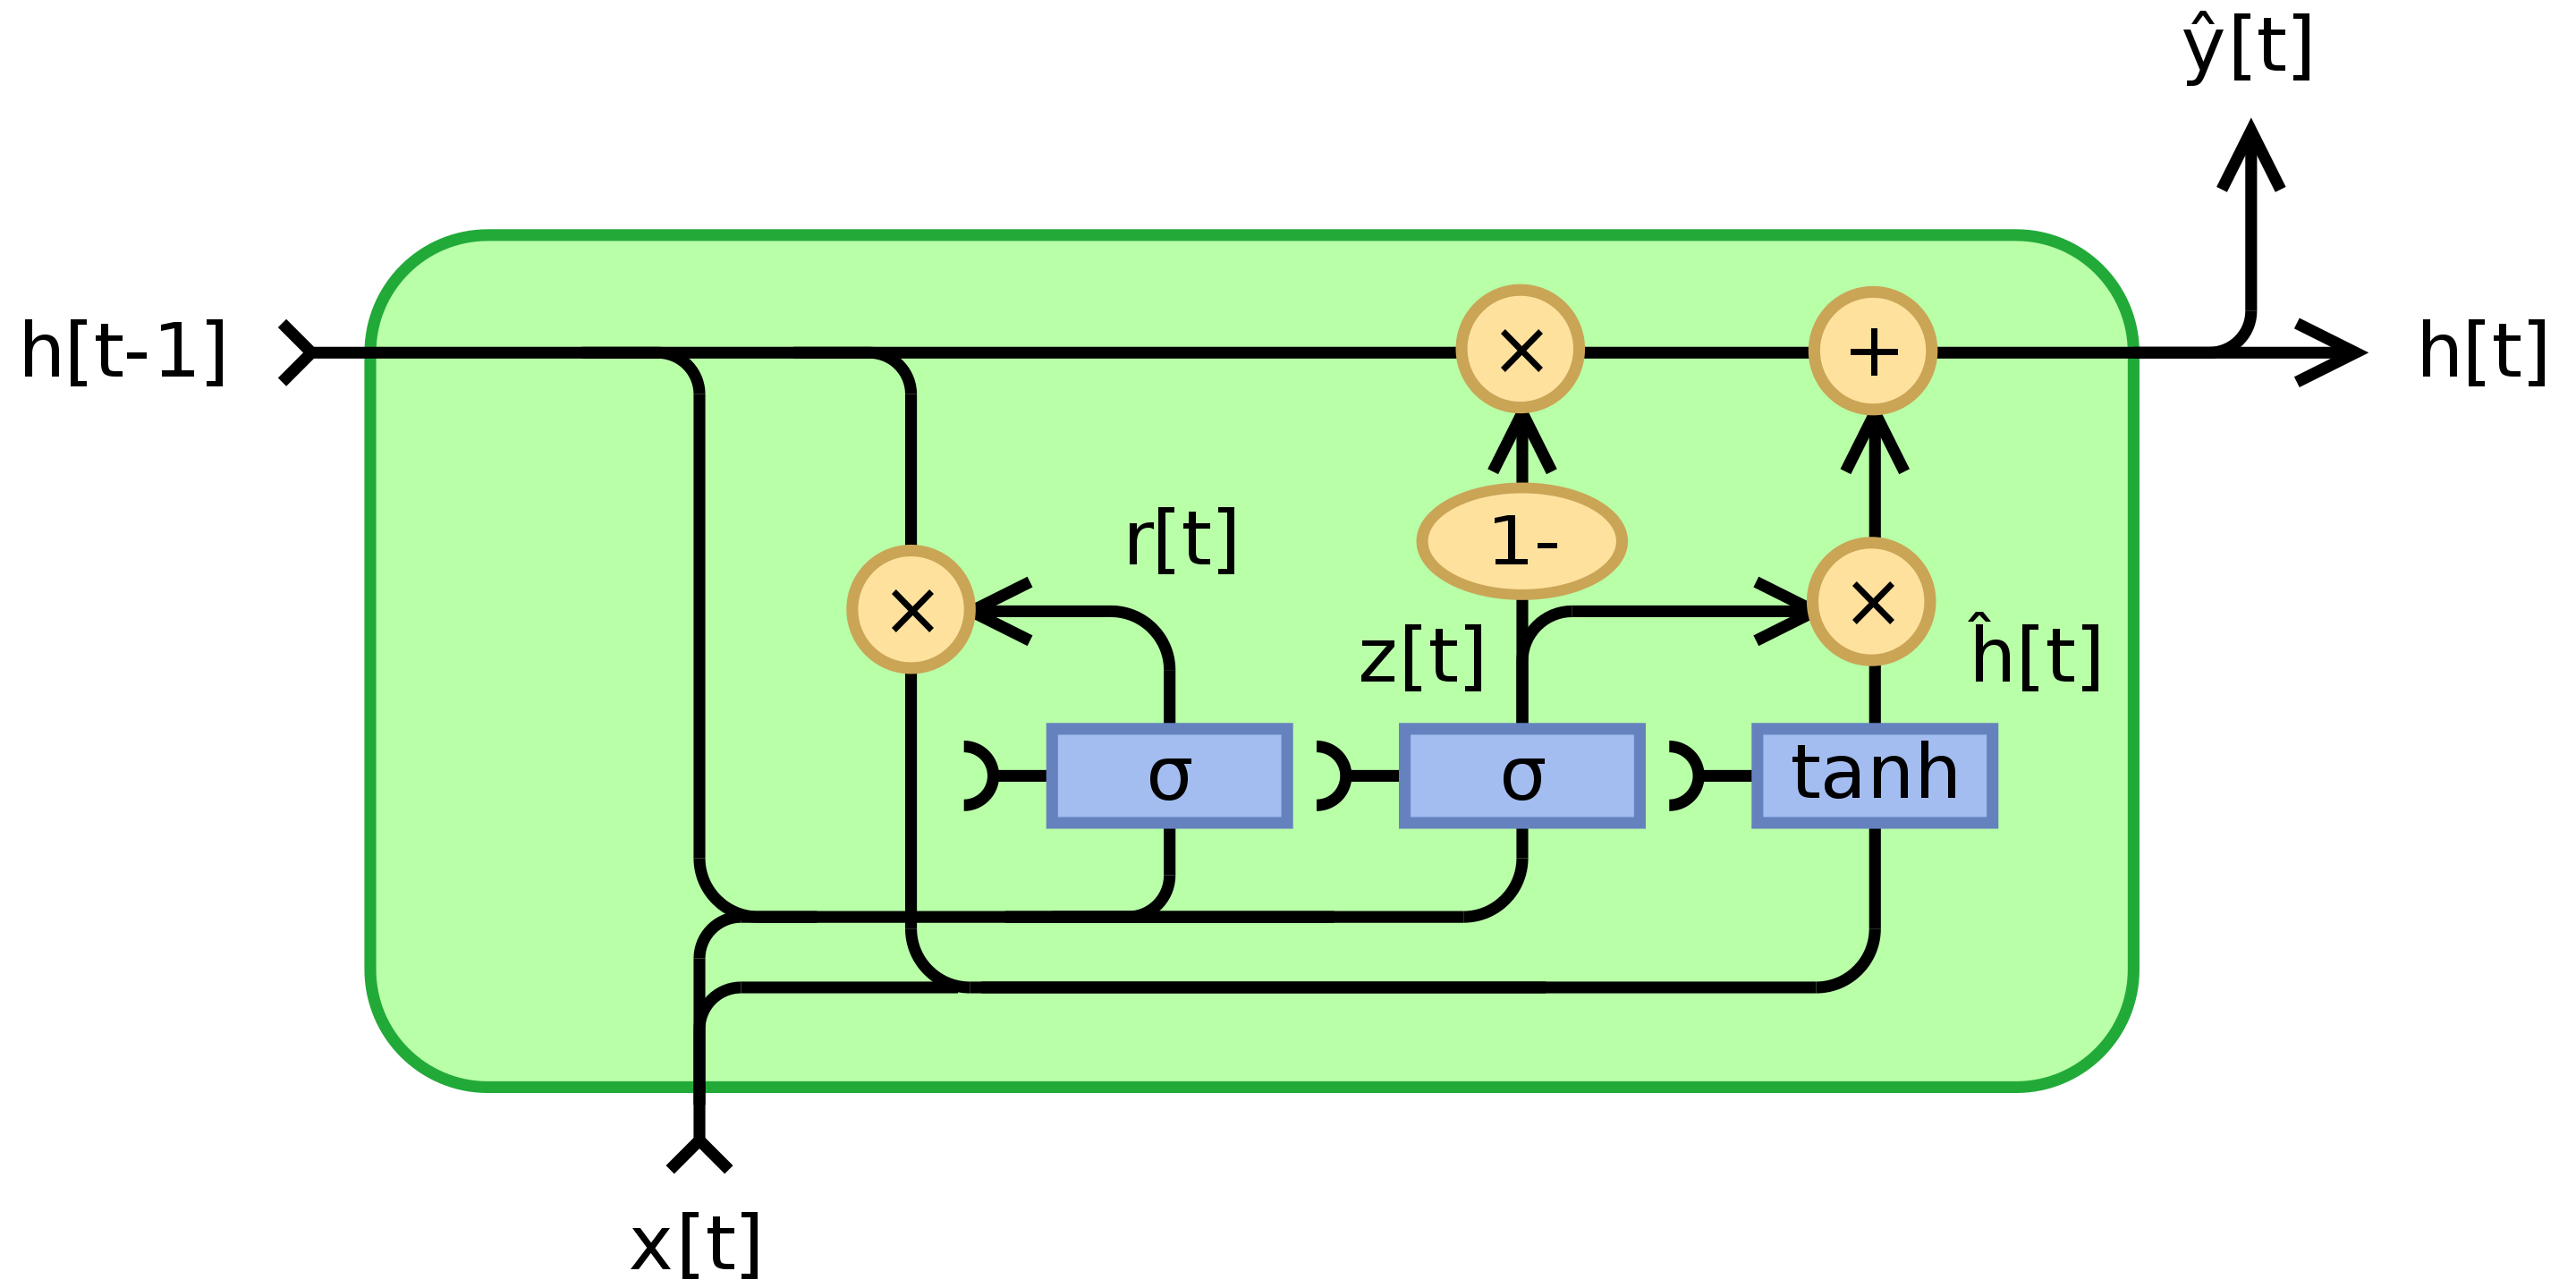

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(x.dot(self.update_w.value) + state.dot(self.update_u.value) + self.update_b.value)

            # fill this in
            reset_gate = objax.functional.sigmoid(x.dot(self.reset_w.value) + state.dot(self.reset_u.value) + self.reset_b.value)
            
            # fill this in
            output_gate = objax.functional.tanh(x.dot(self.output_w.value) + (reset_gate*state).dot(self.output_u.value) + self.output_b.value)
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7 (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?**

It sends in tracable variable that scans and learns the function. Then it optimizes it. One good example of lax.scan usage is a cumulative summation. When perfomring cumulative sum through code, the current loop information is used to update the information from the previous loop - it is convoluted. Using the lax scan, we get two objects, 'carryover' that gets carried over to the next loop and 'accumulated' that accumulates into an array. This speeds up the process of calculating the cummulative sum. 

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:
gru_rnn = objax.nn.Sequential([Embed(max_vocab,embedding_size), GRU(embedding_size, num_hidden_units_GRU), objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

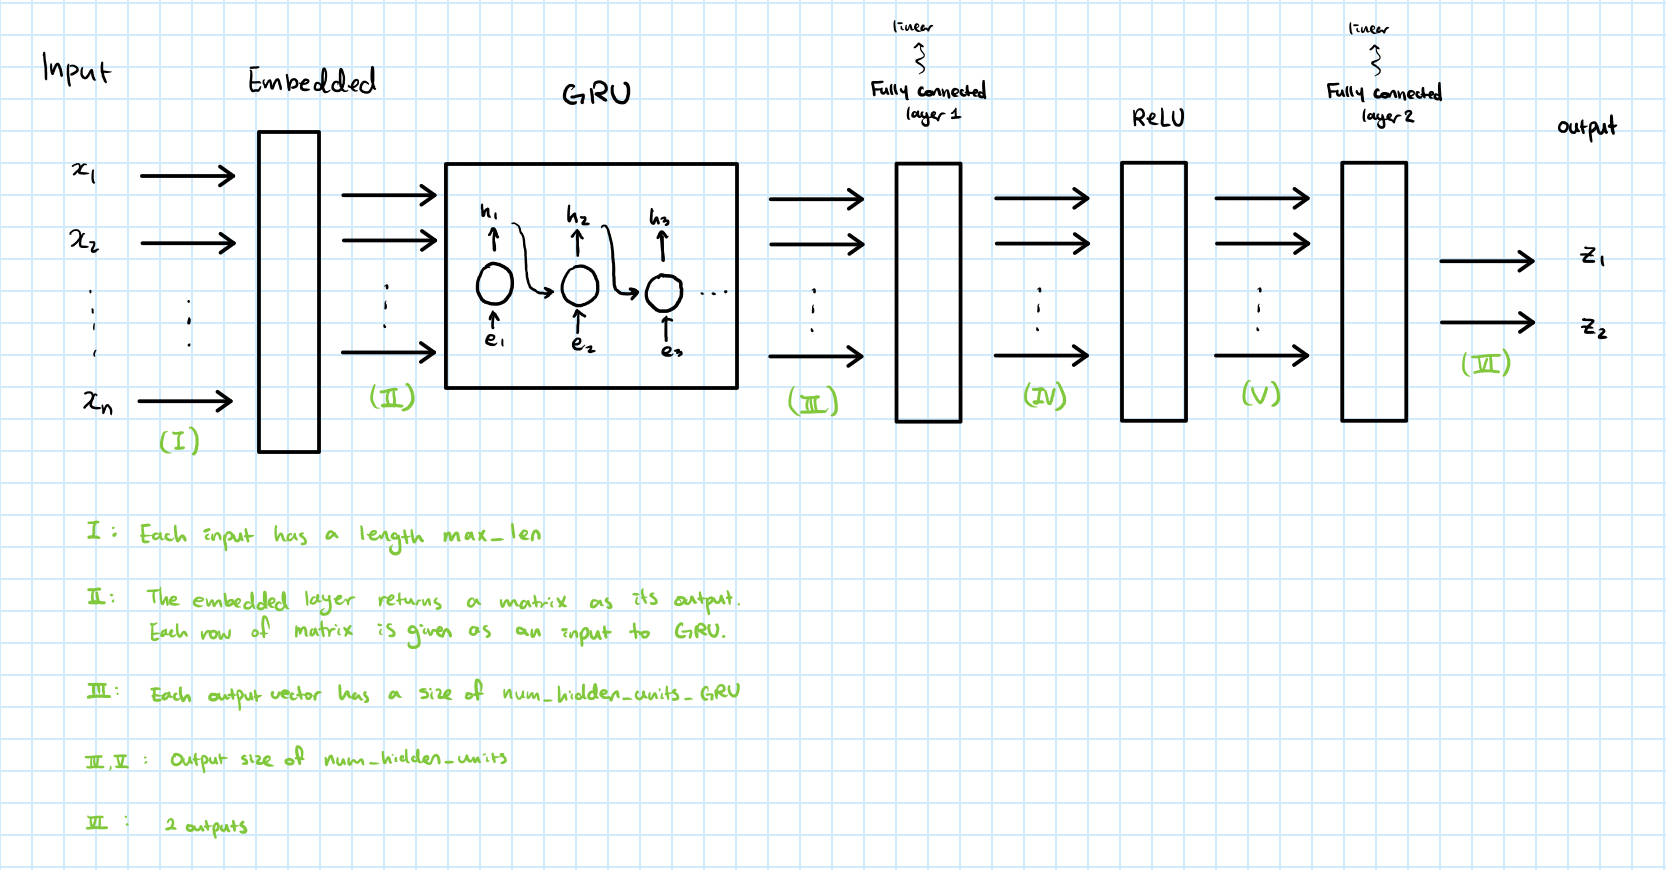

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:

def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
avg_train_loss_epoch = []
avg_val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []

for epoch in range(num_epochs):
  avg_train_loss = 0 # (averaged) training loss per batch
  avg_val_loss =  0  # (averaged) validation loss per batch
  train_acc = 0      # training accuracy per batch
  val_acc = 0        # validation accuracy per batch

  train_indices = np.arange(len(training_data[0])) 
  np.random.shuffle(train_indices)
  for it in range(0, training_data[0].shape[0], batch_size):
    batch = train_indices[it:it+batch_size] 
    avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], learning_rate)[0]) * len(batch)
    train_prediction = eval_op(training_data[0][batch]).argmax(1)
    train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
  train_acc_epoch.append(train_acc/training_data[0].shape[0])
  avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

  val_indices = np.arange(len(validation_data[0])) 
  np.random.shuffle(val_indices)    
  for it in range(0, validation_data[0].shape[0], batch_size):
    batch = val_indices[it:it+batch_size] #PUT YOUR CODE HERE#
    avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
    val_prediction = eval_op(validation_data[0][batch]).argmax(1)
    val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
  val_acc_epoch.append(val_acc/validation_data[0].shape[0])
  avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

  print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/training_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))

Epoch 0001  Training Loss 172.57 Validation Loss 21.38 Training Accuracy 55.46 Validation Accuracy 57.44
Epoch 0002  Training Loss 168.11 Validation Loss 20.64 Training Accuracy 60.59 Validation Accuracy 58.30
Epoch 0003  Training Loss 162.18 Validation Loss 19.94 Training Accuracy 63.40 Validation Accuracy 62.48
Epoch 0004  Training Loss 154.69 Validation Loss 18.34 Training Accuracy 66.62 Validation Accuracy 69.14
Epoch 0005  Training Loss 148.91 Validation Loss 18.28 Training Accuracy 69.18 Validation Accuracy 69.54
Epoch 0006  Training Loss 144.79 Validation Loss 17.44 Training Accuracy 71.15 Validation Accuracy 70.60
Epoch 0007  Training Loss 141.93 Validation Loss 15.62 Training Accuracy 72.41 Validation Accuracy 76.10
Epoch 0008  Training Loss 138.34 Validation Loss 15.86 Training Accuracy 73.31 Validation Accuracy 76.10
Epoch 0009  Training Loss 135.12 Validation Loss 14.63 Training Accuracy 74.62 Validation Accuracy 78.96
Epoch 0010  Training Loss 131.49 Validation Loss 14.73 

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

Test Accuracy 85.48
Generalization Gap: 0.51


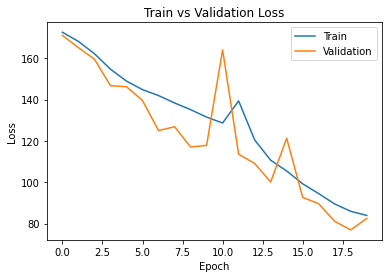

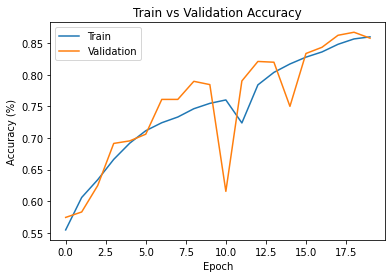

In [ ]:
test_loss = 0 # (averaged) loss per batch
test_acc = 0      # training accuracy per batch

# shuffle the data prior to training to remove correlation 
test_indices = np.arange(len(test_data[0])) 
np.random.shuffle(test_indices)
batch_size = 1 

for it in range(0, test_data[0].shape[0], batch_size): 
  batch = test_indices[it:it+batch_size] 
  test_prediction = eval_op(test_data[0][batch]).argmax(1)
  test_acc += (np.array(test_prediction).flatten() == test_data[1][batch]).sum()
    
print('Test Accuracy %.2f' % (100*test_acc/test_data[0].shape[0]))

gen_gap_train_acc = 100*train_acc/training_data[0].shape[0]
gen_gap_test_acc = 100*test_acc/test_data[0].shape[0]

print('Generalization Gap: %.2f' % (gen_gap_train_acc - gen_gap_test_acc))

#Plot training loss
plt.title("Train vs Validation Loss")
plt.plot(avg_train_loss_epoch, label="Train")
plt.plot(avg_val_loss_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([Embed(max_vocab,embedding_size), GRU(embedding_size, num_hidden_units_GRU), objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), objax.functional.relu, objax.nn.Linear(num_hidden_units, 2)])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:
# you code for the training loop should start here 
avg_train_loss_epoch = []
avg_val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []

for epoch in range(num_epochs):
  avg_train_loss = 0 # (averaged) training loss per batch
  avg_val_loss =  0  # (averaged) validation loss per batch
  train_acc = 0      # training accuracy per batch
  val_acc = 0        # validation accuracy per batch

  train_indices = np.arange(len(training_data[0])) 
  np.random.shuffle(train_indices)
  for it in range(0, training_data[0].shape[0], batch_size):
    batch = train_indices[it:it+batch_size] 
    avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], learning_rate)[0]) * len(batch)
    train_prediction = eval_op(training_data[0][batch]).argmax(1)
    train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
  train_acc_epoch.append(train_acc/training_data[0].shape[0])
  avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

  val_indices = np.arange(len(validation_data[0])) 
  np.random.shuffle(val_indices)    
  for it in range(0, validation_data[0].shape[0], batch_size):
    batch = val_indices[it:it+batch_size] #PUT YOUR CODE HERE#
    avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
    val_prediction = eval_op(validation_data[0][batch]).argmax(1)
    val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
  val_acc_epoch.append(val_acc/validation_data[0].shape[0])
  avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])


  print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/training_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))


Epoch 0001  Training Loss 122.66 Validation Loss 9.89 Training Accuracy 75.81 Validation Accuracy 86.64
Epoch 0002  Training Loss 74.82 Validation Loss 9.23 Training Accuracy 88.32 Validation Accuracy 87.14
Epoch 0003  Training Loss 68.82 Validation Loss 8.75 Training Accuracy 89.37 Validation Accuracy 87.88
Epoch 0004  Training Loss 62.69 Validation Loss 8.74 Training Accuracy 90.42 Validation Accuracy 88.34
Epoch 0005  Training Loss 59.76 Validation Loss 8.94 Training Accuracy 91.03 Validation Accuracy 87.78
Epoch 0006  Training Loss 57.48 Validation Loss 9.06 Training Accuracy 91.26 Validation Accuracy 88.26
Epoch 0007  Training Loss 55.40 Validation Loss 8.93 Training Accuracy 91.64 Validation Accuracy 88.00
Epoch 0008  Training Loss 51.68 Validation Loss 9.59 Training Accuracy 92.43 Validation Accuracy 87.18
Epoch 0009  Training Loss 48.12 Validation Loss 9.23 Training Accuracy 93.09 Validation Accuracy 87.96
Epoch 0010  Training Loss 44.40 Validation Loss 9.60 Training Accuracy 9

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

Test Accuracy 86.74
Generalization Gap: 10.93


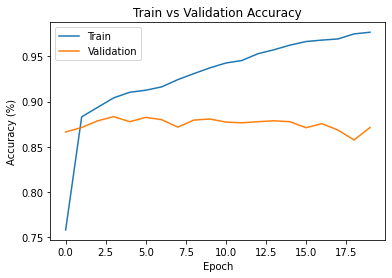

In [ ]:
test_loss = 0 # (averaged) loss per batch
test_acc = 0      # training accuracy per batch

# shuffle the data prior to training to remove correlation 
test_indices = np.arange(len(test_data[0])) 
np.random.shuffle(test_indices)
batch_size = 1 

for it in range(0, test_data[0].shape[0], batch_size): 
  batch = test_indices[it:it+batch_size] 
  test_prediction = eval_op(test_data[0][batch]).argmax(1)
  test_acc += (np.array(test_prediction).flatten() == test_data[1][batch]).sum()
    
print('Test Accuracy %.2f' % (100*test_acc/test_data[0].shape[0]))

gen_gap_train_acc = 100*train_acc/training_data[0].shape[0]
gen_gap_test_acc = 100*test_acc/test_data[0].shape[0]

print('Generalization Gap: %.2f' % (gen_gap_train_acc - gen_gap_test_acc))

#Plot training loss

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

**Questions 15 [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.**

Gradient decent is a popular deep neural network optimizer that observes the impact of the changes in the parameter to the objective function and goes in the direction that would lower the error rate. It iterates then terminates when the object function converges to the minimum.

Stochastic Gradient Descent is one of the many kinds of the gradient decents. Its differentiation comes from the note that it uses a subset (either random or not)of data to compute.  

Adam is also another graident-based optimizer but it also uses stochastic objective functions. So, it utlizes two advangae of the two SGD extensions - Root Mean Square Propagation and Advapvie Gradient Algorithm - to compute individual advative learning rates for different parameter. 

According to a quick research, the general comparison of the two optimizers is that Adam converges faster but SGD generalizes better. This is also illustrated on my outputs where the generalization gap for SGD was 0.51 while the generalization gap for Adam was 10.93. 


# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
  Embed(max_vocab,embedding_size), 
  GRU(embedding_size, num_hidden_units_GRU),
  objax.nn.Linear(num_hidden_units_GRU, num_hidden_units), 
  objax.functional.relu, 
  objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

Epoch 0001  Training Loss 118.53 Validation Loss 9.94 Training Accuracy 76.63 Validation Accuracy 86.28
Epoch 0002  Training Loss 74.77 Validation Loss 9.20 Training Accuracy 88.29 Validation Accuracy 87.78
Epoch 0003  Training Loss 68.82 Validation Loss 8.80 Training Accuracy 89.23 Validation Accuracy 87.60
Patience Window count:  1
Epoch 0004  Training Loss 65.72 Validation Loss 8.81 Training Accuracy 89.68 Validation Accuracy 87.58
Patience Window count:  2
Epoch 0005  Training Loss 63.87 Validation Loss 8.79 Training Accuracy 90.15 Validation Accuracy 87.94
Epoch 0006  Training Loss 61.29 Validation Loss 8.63 Training Accuracy 90.52 Validation Accuracy 88.24
Epoch 0007  Training Loss 58.35 Validation Loss 8.89 Training Accuracy 90.97 Validation Accuracy 88.20
Patience Window count:  3
Epoch 0008  Training Loss 56.14 Validation Loss 9.20 Training Accuracy 91.44 Validation Accuracy 88.02
Patience Window count:  4
Epoch 0009  Training Loss 53.39 Validation Loss 9.48 Training Accuracy 

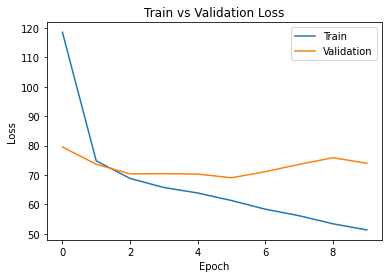

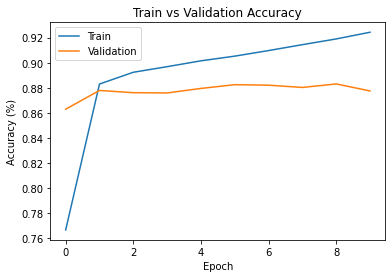

In [ ]:
# you code for the training loop should start here 
avg_train_loss_epoch = []
avg_val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []
counter = 0 

for epoch in range(num_epochs):
  avg_train_loss = 0 # (averaged) training loss per batch
  avg_val_loss =  0  # (averaged) validation loss per batch
  train_acc = 0      # training accuracy per batch
  val_acc = 0        # validation accuracy per batch

  train_indices = np.arange(len(training_data[0])) 
  np.random.shuffle(train_indices)

  for it in range(0, training_data[0].shape[0], batch_size):
    batch = train_indices[it:it+batch_size] 
    avg_train_loss += float(train_op(training_data[0][batch], training_data[1][batch], learning_rate)[0]) * len(batch)
    train_prediction = eval_op(training_data[0][batch]).argmax(1)
    train_acc += (np.array(train_prediction).flatten() == training_data[1][batch]).sum()
  train_acc_epoch.append(train_acc/training_data[0].shape[0])
  avg_train_loss_epoch.append(avg_train_loss/training_data[0].shape[0])

  val_indices = np.arange(len(validation_data[0])) 
  np.random.shuffle(val_indices)    
  for it in range(0, validation_data[0].shape[0], batch_size):
    batch = val_indices[it:it+batch_size] #PUT YOUR CODE HERE#
    avg_val_loss += float(loss_function(validation_data[0][batch], validation_data[1][batch])) * len(batch)
    val_prediction = eval_op(validation_data[0][batch]).argmax(1)
    val_acc += (np.array(val_prediction).flatten() == validation_data[1][batch]).sum()
  val_acc_epoch.append(val_acc/validation_data[0].shape[0])
  avg_val_loss_epoch.append(avg_val_loss/validation_data[0].shape[0])

  print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/training_data[0].shape[0], avg_val_loss/training_data[0].shape[0], 100*train_acc/training_data[0].shape[0], 100*val_acc/validation_data[0].shape[0]))

  if (val_acc_epoch[epoch]) < max(val_acc_epoch):
    counter += 1
    print("Patience Window count: ", counter)
    if (counter >= max_patience_window):
      print("Max number of patience window reached")
      break 

#Plot training loss
plt.title("Train vs Validation Loss")
plt.plot(avg_train_loss_epoch, label="Train")
plt.plot(avg_val_loss_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()
  

Test Accuracy 87.98
Generalization Gap: 4.45


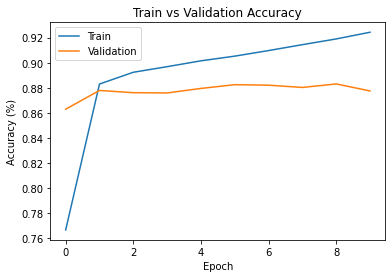

In [ ]:
test_loss = 0 # (averaged) loss per batch
test_acc = 0      # training accuracy per batch

# shuffle the data prior to training to remove correlation 
test_indices = np.arange(len(test_data[0])) 
np.random.shuffle(test_indices)
batch_size = 1 

for it in range(0, test_data[0].shape[0], batch_size): 
  batch = test_indices[it:it+batch_size] 
  test_prediction = eval_op(test_data[0][batch]).argmax(1)
  test_acc += (np.array(test_prediction).flatten() == test_data[1][batch]).sum()
    
print('Test Accuracy %.2f' % (100*test_acc/test_data[0].shape[0]))

gen_gap_train_acc = 100*train_acc/training_data[0].shape[0]
gen_gap_test_acc = 100*test_acc/test_data[0].shape[0]

print('Generalization Gap: %.2f' % (gen_gap_train_acc - gen_gap_test_acc))

#Plot training loss

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

In [ ]:
print("max validation accuracy:", max(val_acc_epoch)*100)

max validation accuracy: 88.3



*   Best validation accuracy: 88.3 
*   Best test accuracy: 87.98


These are the validation accuracy and the test accruacy of Adam optimizer with early stopping. 